# Lab 1: 

This lab will teach you just about everything that you need to know to understand what happens in the `detached_step` of POSYDON's binary evolution.

Goals:
+ Learn what happens in `step_detached`
+ Know how to alter the various options of `step_detached`
+ Understand what phenomena occur in `step_detached`

## 1. POSYDON's Detached Evolution Steps

+ `step_detached`:
  - this step is used to further evolve a detached, non-interacting binary. If the binary experiences RLO, this step ends, and the binary is directed to `step_mesa` to further evolve the binary through the interaction.
+ `step_disrupted`:
  - If a binary system is disrupted after a supernova, it could leave behind a single `HMS` or `HeMS` star. These stars are directed to this step to continue their evolution as isolated single stars.
+ `step_initially_single`:
  - If a star starts out by itself, it will go here and the evolution is handled in the same way as stars that are in a detached binary system.

Out of all steps in POSYDON, the `detached_step` is one of the more complex ones. The way it works is like this:

1. If a binary becomes detached, it will be sent here.
2. When it is sent here, each surviving (non-CO) star is matched to a model from our single star MESA grids.
3. After matching, a set of differential equations is solved to evolve the orbit, until either RLOF happens or a star reaches the end of its life.

While these steps rely on `MESA` models to track and use stellar properties, the orbit is evolved entirely analytically. We will see the different phenomena considered in this evolution step, which includes tides, magnetic braking, gravitational wave radiation, and stellar winds. We will start off looking at some of the technical details of how `step_detached` works, specifically, how it matches fully modeled binary stellar evolution models to a part of non-rotating single star models. In analyzing and discussing your results, this is an important detail to have in the back of your mind, because ultimately, we are having to make a few compromises in order to capture some of the complexity of binary stellar evolution that we can't model easily yet with MESA.

(*You may wonder why we even need a detached step to model binary evolution in the first place. The reason for that is largely to address some limitations of our current set of binary MESA stellar evolution grids. All of our binaries assume an eccentricity of zero,but things like supernova kicks will result in a non-zero eccentricity. Rather than running a whole new dimension of MESA models to vary eccentricity, analytically evolving the orbit saves us substantial compute time.*)

## 1.1 The Single Stars

Besides POSYDON's binary star models, it also comes with a set of non-rotating single star evolution models at all 8 metallicities. Every time a binary system becomes detached, its stars are matched to one of the `MESA` models in these single star grids. You can see in the Figure below from the [POSYDON v2 paper](https://ui.adsabs.harvard.edu/abs/2024arXiv241102376A/abstract) what the hydrogen main sequence models look like.

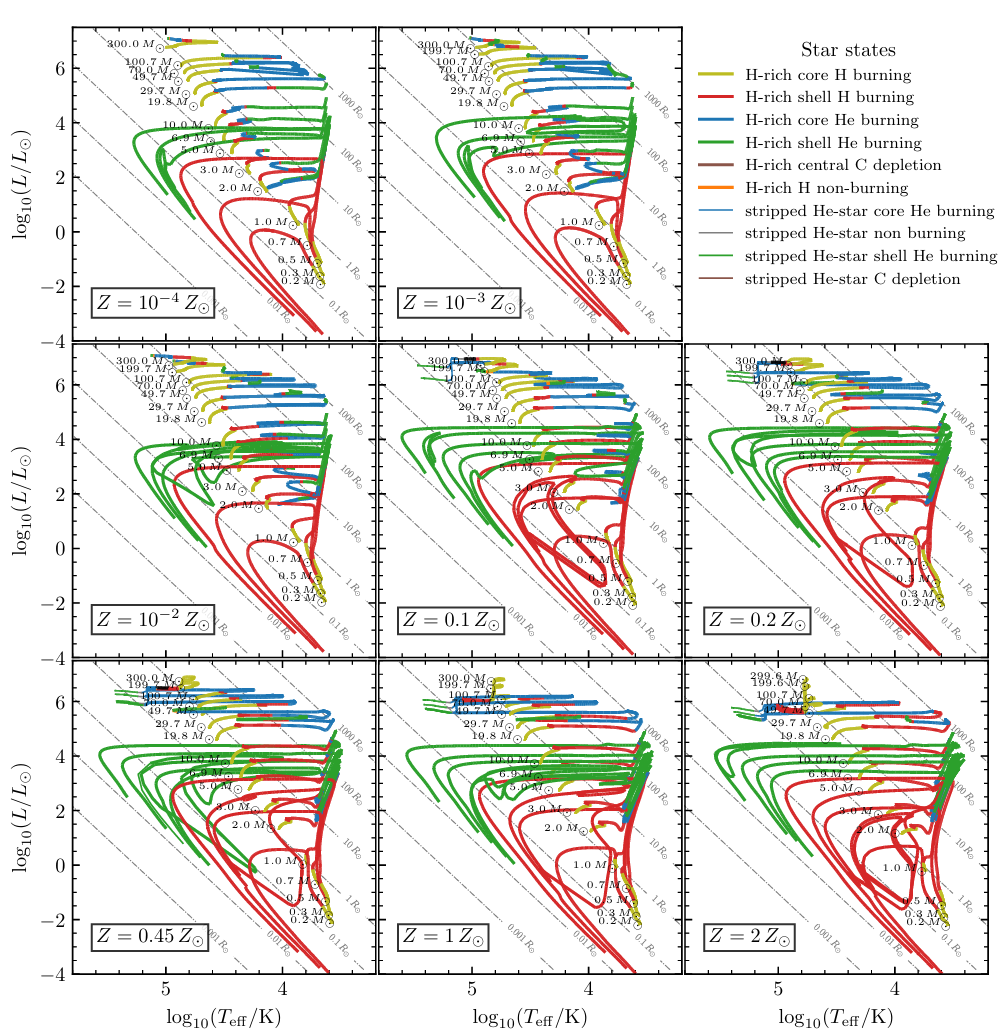

These models cover a range of masses from $\rm 0.1 - 300\ M_{\odot}$. While that is a lot of models, it is unlikely that the plethora of outcomes from binary evolution will be able to find a perfect match when it enters `step_detached`, although we try to make the matches as close as possible. You will see below a bit on how good or bad the matches can be. Before we move on, you should also have a look at the single Helium star grid:

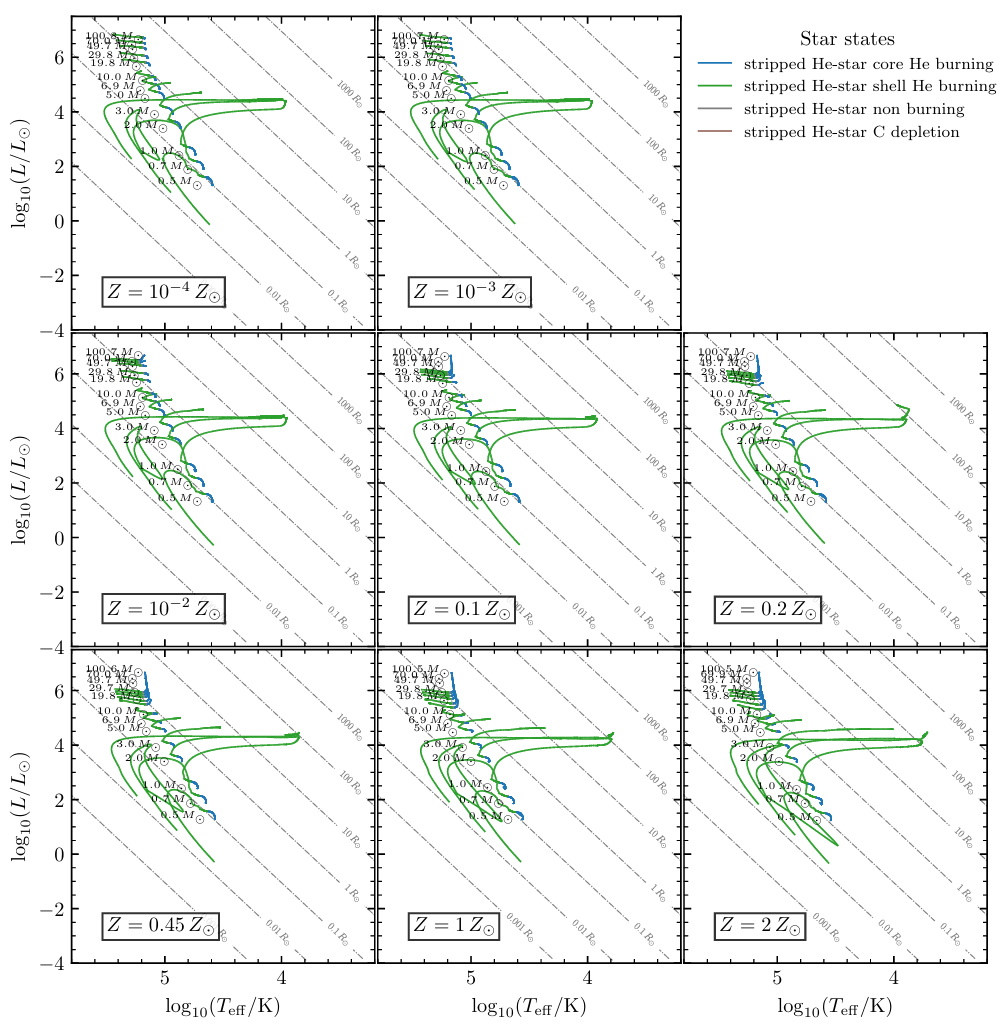

As a result of stable mass transfer, a donor star can have its hydrogen envelope entirely stripped, leaving behind a Helium star. So, we need to account for this possibility in our modeling as well, which is what this grid of models allows for. When a star enters `step_detached`, we check its evolutionary state and several stellar properties to determine whether it is better represented by a hydrogen or helium star, match it, and then proceed with the evolution.

## 1.2 Evolving in Isolation

Let's take a look at an example binary that goes through detached evolution to see all of this in action. We'll copy over the default `.ini` file to start with.

In [ ]:
from posydon.config import PATH_TO_POSYDON
import os
import shutil

path_to_default_params = os.path.join(PATH_TO_POSYDON, "posydon/popsyn/population_params_default.ini")
my_ini_path = shutil.copyfile(path_to_default_params, "./population_params.ini")

To run a binary, we need to provide it with a `SimulationProperties` instance that has all of the evolution steps loaded. We can do that using `SimulationProperties.from_ini()` with the `load_steps=True` option. We will also need to import `BinaryStar` and `SingleStar`, so let's import those too.

In [ ]:
from posydon.binary_evol.simulationproperties import SimulationProperties
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.singlestar import SingleStar

my_ini_path = 'population_params.ini'
sim_prop = SimulationProperties.from_ini(my_ini_path, load_steps=True)

We are now ready to run a `BinaryStar`.

Let's set the initial masses and orbital period of a binary system such that it is likely to enter the `detached_step`. To make sure that happens, we can make the binary very wide, and the masses fairly small so that the two stars are unlikely to expand enough in their lifetime to initiate Roche lobe overflow.

In [ ]:
# let's define a function to automate creating a binary system at ZAMS
def create_a_ZAMS_binary(m1, m2, ini_porb_days, sim_props):

    """

    Handles creating a binary star system of two hydrogen main sequence 
    stars at ZAMS of given masses m1 and m2 at an initial orbital 
    period of ini_porb_days.

    Parameters
    ----------
    m1 : float
        This is the initial mass of star 1 (should be the larger of the two).

    m2 : float
        This is the initial mass of star 2 (the less massive one).

    ini_porb_days : float
        The initial orbital period of the system in days.

    sim_props : SimulationProperties
        The SimulationProperties object containing flow and evolution 
        steps for binary star evolution.

    Returns
    -------
    binary : BinaryStar
        This is the created BinaryStar object.

    """

    # set up some initial properties for the stars and binary:
    # we organize the initial properties into a dictionary:
    s1_ini = {}
    s1_ini['mass'] = m1
    s1_ini['state'] = 'H-rich_Core_H_burning'
    s1_ini['metallicity'] = 1.

    # Do the same for star 2
    s2_ini = {}
    s2_ini['mass'] = m2
    s2_ini['state'] = 'H-rich_Core_H_burning'
    s2_ini['metallicity'] = 1.

    # Set up some initial properties for the binary system:
    bin_ini ={}
    bin_ini['time'] = 0.0
    bin_ini['state'] = 'detached'
    bin_ini['event'] = 'ZAMS'
    bin_ini['orbital_period'] = ini_porb_days

    # create the SingleStars and BinaryStar
    star_1 = SingleStar(**s1_ini)
    star_2 = SingleStar(**s2_ini)
    binary = BinaryStar(star_1, star_2, **bin_ini, properties = sim_props)

    return binary

In [ ]:
# use our function to create the binary
binary = create_a_ZAMS_binary(m1 = 9.0, m2 = 1.0, ini_porb_days = 100_000, sim_props=sim_prop)

# limit the data to a selection
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period']

# evolve it
binary.evolve()
# and show the history DataFrame
binary.to_df(extra_columns={'step_names':'string'})[cols]

You can see that both of the stars pretty much spend their entire lives in isolation. The stars are far enough apart that they start off detached. Eventually the primary star has a core collapse and supernova that disrupts the system (recall that `step_disrupted` is just a child class of `step_detached` and operates the same), leaving behind a neutron star. The companion solar mass star reaches the end of nuclear burning after a while and becomes a white dwarf, but the system has no way to recover from being disrupted after the first supernova and the two stars are so far apart that they never interact.

There's a lot happening under the hood here. Although you can not see it, the secondary star is matched to a single star model when the system enters `step_disrupted`. In order to see that, we need to set `verbose = True` for `step_disrupted` (either in our `.ini` file or just by reloading `step_disrupted` with those options turned on). We should also set `record_matching = True`, which will record the matching event in the binary's history `DataFrame`. Since we will need them later, let's import all of the different types of `step_detached` now too.

In [ ]:
from posydon.binary_evol.DT.step_disrupted import DisruptedStep
from posydon.binary_evol.DT.step_detached import detached_step

# define the evolution step tuple for step_disrupted with record_matching = True and verbose = True 
step_tup = (DisruptedStep, {'record_matching':True, 'verbose':True})

# reload the step with these new options turned on
sim_prop.load_a_step("step_disrupted", step_tup)

# recreate the binary with the updated SimulationProperties
binary = create_a_ZAMS_binary(m1 = 9.0, m2 = 1.0, ini_porb_days = 100_000, sim_props=sim_prop)

# and evolve it!
binary.evolve()

## 1.3 Inspecting the Matching Process of `step_detached`
In the output above, you should be able to see some more details about the matching process. You can scroll in the cell above and have a look for yourself, but let's disect this bit:
___

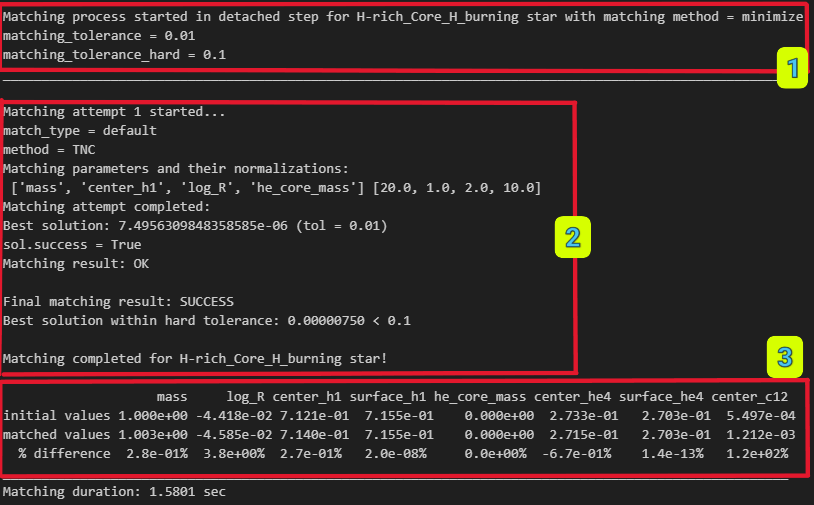

___
Starting from the top, what's being shown is:

1. Some initial parameters, like the state of the `SingleStar` that is being matched.
2. The outcome of matching attempts. It is possible that up to four matching attempts may be made, but this one is successful in the first one.
3. A table showing you some of the initial stellar properties and the values of the matched star for comparison.

The rest of the output that follows is somewhat technical, showing you output that is related to the analytical calculations of `step_detached`.

You can see that in this case, the match is pretty close, with the mass being off by only 0.28%, the log radius off by 3.8%, and the abundances off (for the most part) by no less than 1%. You will notice that the central carbon abundance of the match is off by 120%, but the actual values are fairly small; as a hydrogen main sequence star, this difference is unlikely to have a large effect on the subsequent evolution in this case.

If you ever need to understand (or are just curious about) what happened during the matching step of a binary that you are looking at, it is a good idea to evolve it yourself with these outputs turned on to investigate things a little deeper. For the most part, you will probably find the evolution of your binaries goes without error. There are relatively rare cases though where you may see a mass jump a bit too much when you are looking at binaries in your populations; this can be indicative of a bad match and warrant further investigation to track down the issue and develop a solution.

Before moving on, we should look at what the `record_matching` option actually does. To do that, we have to look at the binary history.

In [ ]:
binary.to_df(extra_columns={'step_names':'string'})[cols]

Look for the line above that shows the `Match2` event. Setting `record_matching = True` in your `SimulationProperties` will mean that whenever a star is matched to a single star track, we record the properties of star at match so that you can evaluate how good the match is at a glance. You will see either `Match1`, `Match2`, or `Match12` as the event, which tells you if star 1, 2, or both stars were matched to single stars in that step. Here you can see the mass matches what was found by the match as shown in the terminal output just above. We went from a 0.9999 solar mass star to a 1.003 solar mass star -- a small increase as a result of matching, but unlikely to alter the outcome of binary evolution very much if at all.

# 2. Tides, Magnetic Braking, and Everything Else

Now we have seen very broadly how `step_detached` works and how you can analyze the matching process that occurs within it, but we will now get into the details a bit more and get our hands dirty by tinkering with the step itself, to see how it handles binary star evolution. As mentioned at the start, this step evolves the binary orbit through analytical calculations, primarily solving several differential equations that affect the angular momentum budget of the orbit. These calculations will continue until either one of the stars dies or if one initiates Roche lobe overflow, which will trigger POSYDON to decide on where to send the binary next in the `flow_chart`.

If you look at the options for `step_detached` in your `.ini` file, you will see several options that we will focus on:

___
```python
  do_wind_loss = True
    # True, False
  do_tides = True
    # True, False
  do_gravitational_radiation = True
    # True, False
  do_magnetic_braking = True
    # True, False
  do_stellar_evolution_and_spin_from_winds = True
    # True, False
```
___
Here, `do_wind_loss` sets whether or not to account for any orbital angular momentum lost to stellar winds and `do_stellar_evolution_and_spin_from_winds` sets whether or not to account for stellar angular momentum loss via stellar winds. The setting `do_tides` turns on tidal calculations, affecting both the orbit and stellar spin; likewise for `do_magnetic_braking` affecting the stellar spin and `do_gravitational_radiation` affecting the orbital separation. In `step_detached`, only 4 things are actively solved for:

1. The change in orbital separation: $\rm da/dt$ (tides, gravitational radiation, and winds)
2. The change in orbital eccentricity: $\rm de/dt$ (tides, gravitational radiation)
3. The change in the rotation rate of star 1: $\rm d\Omega_{1}/dt$ (magnetic braking and winds)
4. The change in the rotation rate of star 2: $\rm d\Omega_{2}/dt$ (magnetic braking and winds)

With the binary that we evolved above, although it enters `step_detached`, the two stars are so far apart from each other that pretty much only the winds can have an effect (besides magnetic braking affecting the spin of star 2). To make matters worse (if we want to see any of these effect), this system is disrupted by a supernova! So, after that the orbit is effectively non-existent, making most of the changes calculated in `step_detached` irrelevant. In order to see some of these effects more easily, we need to look at a system that is detached, but not disrupted. Ideally, a system whose stars are a bit closer too, so that the effect of tides and possibly gravitational radiation play more of a role.

So, let's design a system that's a bit closer and see what we can learn. Below, we will evolve a binary from a more evolved point, where the primary star has already become a compact object, and the secondary star is a low mass star.

## 2.1 Studying Tides with Low-Mass X-ray Binaries

Low-mass X-ray binaries (LMXBs) are star systems where the primary star has evolved into a compact object (black hole or neutron star in this case) and the secondary is a low-mass star. To date, over 300 LMXBs have been discovered in the Milky Way (see e.g., [Fortin et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...684A.124F/abstract)).

To begin studying the effects of tides, magnetic braking, and mass loss in LMXBs, we will create a system that contains a $\rm 1.4 M_{\odot}$ neutron star (a canonical mass for these compact objects) and a solar mass companion, at an initial orbital period of 2 days. We will start this binary off in the `detached` state; one defining feature of LMXBs is the X-ray emission given off by an accretion disk surrounding the compact object, meaning that at some point an LMXB will reach the Roche lobe overflow (RLOF) state. Thus, our binary will start off detached, but we should see RLOF occur once the low-mass secondary evolves, expands, and begins mass transfer. Furthermore, at an orbital period of 2 days, the stars in this system orbit each other pretty closely which will lead to strong tidal interactions and [tidal locking](https://en.wikipedia.org/wiki/Tidal_locking), similar to the tidal locking that occurs in our Earth-Moon system.

___
<div class='alert alert-success'>
    
#### Exercise 1: Evolving an LMXB
1. Create an LMXB binary as described above. (Although useful at times, you may want to set `record_matching = False` and `verbose = False` in `step_detached` to cut down on terminal output.)
2. Check the history of the binary. At an orbital period of 2 days, we should expect that at least by the end of `step_detached`, tides have caused the binary to become tidally locked. Check whether this happens.
3. Re-evolve the binary, but this time turn tides off (set `do_tides = False` in `step_detached`). How do things change?

<div class='alert alert-warning'>

**(Hint: In the history, be sure to look at `S2_surf_avg_omega` to see the rotation rate of star 2. The units of this property are radians per second.)**

</div>
    
</div>

In [ ]:
# Create an LMXB binary system with a 1.4 solar mass neutron star and a 1 solar mass hydrogen main sequence star at an initial orbital period of 2 days.



# Evolve the binary, and print its output
# To print the history data, you can look at whatever columns you want, but we recommend using the following set of column names, and printing step_names in the history too
#
# cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_surf_avg_omega', 'S2_surf_avg_omega']
# binary.to_df(extra_columns={'step_names':'string'})[cols]


In [ ]:
# Check for tidal synchronization here. Prot/Porb should equal nearly 1 if synchronized. Use the data from the history DataFrame

In [ ]:
# Do the same as step 1, but now, turn tides off in step_detached and reload the step in your SimulationProperties
# (check the examples above or the solution below if you are unsure how to do this, or ask a TA)

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

### 1. To create an LMXB and evolve it
You can create a helper function like we did for the ZAMS binary above to create a `BinaryStar` from two `SingleStar`s.

```python
# A function to handle creating a simple LMXB system
def create_a_co_star_system(star_mass, co_mass, co_type, ini_porb, sim_props):

    # the HMS stellar secondary
    star2 = SingleStar(**{'mass': star_mass,
                          'state': 'H-rich_Core_H_burning'})

    # the compact object primary
    star1 = SingleStar(**{'mass':co_mass,
                          'state': co_type})

    binary = BinaryStar(star1, star2,  
                        **{'time': 0.0,
                           'state': 'detached',
                           'orbital_period':ini_porb},
                           properties = sim_props)
    
    return binary
```

Then you can use the function to create and evolve the binary. Here we also reload `step_detached` in our `SimulationProperties`, making sure that `verbose = False` and `record_matching = False`. You can have those turned on, but we turned them off to cut down on the information that is printed.

```python
# setup `detached_step` with our new options
step_tup = (detached_step, {'record_matching':False, 'verbose':False})

# reload the step to enable these options
sim_prop.load_a_step("step_detached", step_tup)

# create the LMXB
binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

# evolve it
binary.evolve()

# and print the history DataFrame with some useful information
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_spin', 'S2_spin', 'S1_surf_avg_omega', 'S2_surf_avg_omega']
binary.to_df(extra_columns={'step_names':'string'})[cols]
```

### 2. After you have run the binary, you can check for tidal synchronization by looking at whether the rotation period of the secondary star is equal to the rotation period of the orbit. Here is one was to do that.

```python
# Check if star's rotation rate and orbital period are tidally synced
import numpy as np

s2_omega = np.array(binary.star_2.surf_avg_omega_history)
porb = np.array(binary.orbital_period_history)
bin_steps = np.array(binary.step_names)
detached_omega = s2_omega[bin_steps == "step_detached"]
detached_pstar = (1.0/86400.0) * 2 * np.pi / detached_omega
detached_porb = porb[bin_steps == "step_detached"]

print("Orbital period [d]: ", detached_porb)
print("S2 spin period [d]: ", detached_pstar)
print("For star 2, Prot/Porb = ", detached_pstar/detached_porb)
```
The ratio Prot/Porb should be nearly 1.

### Re-evolve the binary, but with tides OFF

```python
# Evolve our LMXB, but turn tides OFF and output its history DataFrame
step_tup = (detached_step, {'record_matching':False, 'verbose':False,
                            'do_tides':False})
sim_prop.load_a_step("step_detached", step_tup)

binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

binary.evolve()

cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_surf_avg_omega', 'S2_surf_avg_omega']
binary.to_df(extra_columns={'step_names':'string'})[cols]
```

You should see an entirely different evolution outcome for the binary with tides turned off.

</details>

___
As you can see in the last exercise, tides can be a decisive factor in how a binary system evolves (especially in tight orbits), leading to very different outcomes depending on the underlying assumptions. Although we will not go in depth, we should spend a little bit of time understanding how POSYDON calculates tides in its simulation to get a better sense of what is going on in your simulations.

### 2.1.1 Tidal Theory

Tides rely directly on the gravitational influence that the two stars have on each other; because of this, tides tend to get weaker the further away things are from each other. As we metioned previously, POSYDON calculates 4 things in `step_detached`: $da/dt$, $de/dt$, $d\Omega_1/dt$, and $d\Omega_2/dt$ -- and tides affects all of these. Let's start to understand the underlying calculationg by looking at how tides impacts the first effect in that list. POSYDON adopts the tidal formalism proposed by [Hut 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....99..126H/abstract); this formalism is adopted nearly ubiquitously in stellar evolution codes, including MESA as well. In this formalism, the change in orbital separation due to tides is:

$$
\frac{da}{dt} = -6\frac{k}{T}q(1+q)\left(\frac{R}{a}\right)^8 \frac{a}{(1-e^2)^{15/2}}\left\{f_1(e^2) - (1-e^2)^{3/2}f_2(e^2)\frac{\Omega}{n}\right\}
$$

There are a lot of terms here, but importantly, we see that this scales with the stellar radius ($R$) divided by the orbital separation ($a$) to the eigth power. So, close orbital systems will be strongly affected by tides, as will large stars. To understand why there is such a strong dependence on the object's size, recall that tidal forces are due to the differential of the gravitational force across the body of the object. The larger an object is, the greater the difference in gravitational pull on its near and far side with respect to an orbiting body, leading to a stronger tidal force; conversely, a much smaller object would feel (relatively speaking) the "same" gravitational pull on its near and far side, leading to a weaker tidal force. The other parameters involved here are the eccentricity, $e$, a structural term, $k/T$, and the mass ratio, $q$. 

You can read [Hut 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....99..126H/abstract) and references therein at your leisure for a deeper understanding, but the three other formulae that we care about in `step_detached` follow a similar story and form. For the change in eccentricity:

$$
\frac{de}{dt} = -27\frac{k}{T}q(1+q)\left(\frac{R}{a}\right)^8 \frac{e}{(1-e^2)^{13/2}}\left\{f_3(e^2) - \frac{11}{18}(1-e^2)^{3/2}f_4(e^2)\frac{\Omega}{n}\right\}
$$

where $n$ is the mean orbital angular velocity (basically $2\pi/P_{orb}$). Then, the change in stellar spins looks like this:

$$
\frac{d\Omega}{dt} = 3\frac{k}{T}\frac{q^2}{r_g^2}\left(\frac{R}{a}\right)^6 \frac{n}{(1-e^2)^{6}}\left\{f_2(e^2) - (1-e^2)^{3/2}f_5(e^2)\frac{\Omega}{n}\right\}
$$

where $r_g$ is the "radius of gyration", defined by $I = M(r_gR)^2$, with $I$ being the moment of inertia. In all cases, tidal effects have a strong dependence on $R/a$ to a high power and, at least for our purposes right now, all of the terms relying on $e$ drop out as we are dealing with circular systems (this won't always be the case though!). There are many more details in tidal theory that we can not hope to cover here, but please ask around and read into the subject more if you are interested! It is a crucial phenomenon in stellar binary evolution and planetary systems, including our own planet, Earth.

By the way, if you are ever curious to see the code that handles these calculations, you can find them in your POSYDON installation, here:

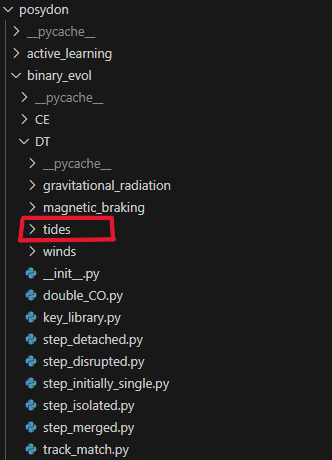

If you have a look inside of `$PATH_TO_POSYDON/posydon/binary_evol/DT/tides/`, you will find `default_tides.py`, which holds all of the code corresponding to the above calculations. You can see in the file tree above that you can similarly find all the default code responsible for graviational radiation, magnetic braking, and winds during `step_detached`. It is possible to modify all of these default prescriptions and put in whatever you want during `step_detached`, which we will get to later.

So, now we've seen a bit on what goes into calculating tides in POSYDON (especially if you had a look at the files mentioned just above). We've only really looked at what happens if we turn tides on or off until now. However, there's actually an interesting connection between the last tidal equation affecting stellar spin and magnetic braking.

### 2.1.2 The Tidal - Magnetic Braking Connection

In `step_detached` (and in reality), magnetic braking affects primarily the spin of a star. This phenomenon occurs in low-mass stars, less than about $\rm 1.5 M_{\odot}$ with thick convective envelopes, like our Sun. These stars all tend to exhibit much more magnetic activity (owing to strong surface magnetic fields) than their more massive counterparts tend to lack. It is thought that these strong surface magnetic fields are driven by stellar dynamos whose nature we are still working to understand. Coupled to outflowing stellar winds, these magnetic fields drive a substantial source of angular momentum loss in low-mass stars, gradually slowing their spins over time. The consequences of this spin down are also a topic of great interest in low-mass stellar astrophysics as refining the theory that surrounds stellar dynamos and magnetic braking has profound consequences for gyrochronology, binary white dwarf systems (important gravitational wave sources in the upcoming *LISA* mission), and in general for stellar and binary astrophysics.

Where magnetic braking and tides connect is through the phenomenon we briefly looked at in Exercise 1: tidal locking. In that Exercise, you should have seen that the stellar spin period and orbital rotation rate matched each other very closely, indicative of tidal locking. Tides will act to synchronize a star's spin period to the orbital period of the system through gravitational forces; without magnetic braking, once the system is locked, tides will no longer remove (or add) angular momentum to the orbit, as the gravitational forces that facilitate these changes becomes negligible in the locked state. However, magnetic braking continually tries to spin a star down, causing tides to contiually try to counteract this spin down. If tides are strong enough, they will cancel out magnetic braking, preventing stellar spin down at the expense of orbital angular momentum which leads to orbital collapse. This collapse can trigger subsequent RLOF, a common envelope and possibly a merging of the two stellar objects.
___

<div class='alert alert-success'>

#### Exercise 2: Magnetic Braking and Tides
1. Create and evolve a LMXB system, just like above, except leave tides on and turn off magnetic braking now. 
2. Compare to the previous evolution with magnetic braking on.

</div>

In [ ]:
# create an LMXB system with tides ON now, and magnetic braking OFF

# print the history DataFrame and compare the outcome to the history from Exercise 1, step 1

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>
    
### 1. Create our LMXB, but with tides ON and magnetic braking OFF

```python
# Re-evolve our LMXB system, but this time with tides ON and magnetic braking turned OFF.
step_tup = (detached_step, {'record_matching':False, 'verbose':False,
                            'do_tides':True, 
                            'do_magnetic_braking': False})

# reload the step with these new options turned on
sim_prop.load_a_step("step_detached", step_tup)

binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

binary.evolve()
```

### 2. Compare to the previous evolution that we saw with magnetic braking and tides both turned on
You should see that instead of merging in the end, you stay detached. This is because really it is taking both tides and magnetic braking acting together to remove angular momentum from the orbit in order to cause a collapse.
</details>

So, we can see how magnetic braking and tides can act together to remove angular momentum from an orbit and change its fate (especially in the low-mass binary systems). You may have also noticed how the case of our default LMXB (a $\rm 1.4 M_{\odot}$ neutron star and a solar mass star at $\rm P_{orb,i}=2$ days) tides and magnetic braking are the dominant factors that influence its evolution in `step_detached`.

## 2.2 Studying Magnetic Braking with LMXBs

Although many people adopt [Hut 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....99..126H/abstract) as a tidal prescription in binary evolution, there is a weaker consensus on how to prescribe the effects of magnetic braking. In binary evolution, the most widely used formalism is that of [Rappaport, Verbunt, and Joss 1983](https://ui.adsabs.harvard.edu/abs/1983ApJ...275..713R/abstract) (RVJ83). Without going into too much of the history, this formalism follows relatively simple arguments based on the observation by [Skumanich 1972](https://ui.adsabs.harvard.edu/abs/1972ApJ...171..565S/abstract) that solar-like stars appear to spin down according to a simple relation $\Omega \propto t^{-1/2}$, where $t$ is the age of the star (this observation by the way -- now known as the "Skumanich Law" -- is largely responsible for establishing interest in [gyrochronology](https://en.wikipedia.org/wiki/Gyrochronology)). The RVJ83 prescription is what both MESA and POSYDON use by default to calculate the effect of magnetic braking on stellar spins in a binary system.

### 2.2.1 Different Magnetic Braking Prescriptions
Since the time of RVJ83, there have been a lot of developments (observationally, many actually coming from the study of nearby single stars in open clusters) and to this day the theory of magnetic braking remains an active area of research. So, POSYDON offers you several options to choose from when you run your simulations. Although RVJ83 is the default, you can also choose from:

+ [Matt et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...799L..23M/abstract): based on 2D MHD simulations, assuming a dipolar magnetic field
+ [Garraffo et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...862...90G/abstract): based on 3D MHD simulations, positing that magnetic field topology plays a strong role
+ [Van & Ivanova 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...886L..31V/abstract): Convection and rotation boosted (CARB) magnetic braking, intended to improve on RVJ83

We can not cover all of these prescriptions in much more detail here, but see e.g. [Gossage et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...950...27G/abstract) for a comparison of these prescriptions. There are even more prescriptions in the literature than these four and as we said, there's no clear choice on which you should use! Perhaps your own research will play a role in resolving the mystery.

As for RVJ83, we can write that the spin of the stars changes according to:

$$
\frac{d\Omega}{dt} = -\frac{6.82\times10^{34}}{I}\left(\frac{M}{M_{\odot}}\right)\left(\frac{R}{R_{\odot}}\right)^{\gamma_{mb}}\left(\frac{\Omega}{2\pi}\right)^3
$$

where $\gamma_{mb}$ is a free parameter, often taken to be equal to $4$ (as we do in POSYDON).

___
<div class='alert alert-success'>
    
#### Exercise 3: Exploring our options
1. Evolve our default LMXB setup from before, this time testing different magnetic braking prescriptions and display their history `DataFrame`s.

<div class='alert alert-warning'>
    
**(Hint: Use the option `magnetic_braking_mode="<MB_OPTION>"`, where `MB_OPTION` is either `RVJ83`, `M15`, `G18`, or `CARB` for the available prescriptions to choose from.)**
    
</div>
</div>

In [ ]:
# Evolve the LMXB with something other than RVJ83

In [ ]:
# Evolve the LMXB with different magnetic braking prescription than the last one

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

### 1. Try out different magnetic braking prescriptions, like Matt et al. 2015

Be sure to reload `step_detached` when you switch options!

```python
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_surf_avg_omega', 'S2_surf_avg_omega']

step_tup = (detached_step, {'record_matching':False, 'verbose':False,
                            'do_tides':True, 
                            'do_magnetic_braking': True,
                            'magnetic_braking_mode':"M15"})

# reload the step with these new options turned on
sim_prop.load_a_step("step_detached", step_tup)

binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

binary.evolve()
binary.to_df(extra_columns={'step_names':'string'})[cols]
```

</details>

___
After you have tried out a few of the different magnetic braking options available and compared the histories, you may see slight differences, but nothing too major. How much of a difference one prescription or the other makes will depend a lot on the system parameters. Right now, we only get a look at what happens at the end of `step_detached`, so we lose a bit of the detail of what is happening during the step itself.

To remind you, `step_detached` is solving the differential equations (like the ones we have seen for tides and magnetic braking) through time. It is not as detailed as MESA, which solves full stellar structure, but it is pretty good for solving simple evolution of the orbit and stellar spins in this phase of evolution. When you simulate populations and perform some analysis on them, you may get to the point where you want to study particular systems in greater detail and test the effect of different assumptions during `step_detached`. We just saw how we have some freedom to change our assumed magnetic braking prescriptions, but we can get even more detailed if we want a better picture of what is happening during `step_detached`.

## 2.3 Time Evolution During `step_detached`

To demonstrate this, we will continue our study of magnetic braking in LMXB systems. In order to see the time evolution that is happening during `step_detached`, we need to supply this step with another option called `dt`, which is the timestep that we want to sample the evolution with. The units for `dt` are years and its important not to pick something too small, as it can cause some issues with the solution of the differential equations (by the way, in case you're curious how POSYDON solves these equations, it makes use of `SciPy`'s built-in function [`solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)).

Here's an example of how we can see the time evolution of our LMXB's orbital period using the default RVJ83 magnetic braking prescription.

In [ ]:
# some selection of data columns to slice our DataFrames with
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_surf_avg_omega', 'S2_surf_avg_omega']


# We will sample time evolution during step_detached with this
dt = 1e7 # [yrs]

# pass new desired options for the detached step:
step_tup = (detached_step, {'record_matching':False, 'verbose':False,
                            'do_tides':True, 
                            'do_magnetic_braking': True,
                            'magnetic_braking_mode':"RVJ83",
                            'dt': dt})

# reload the step with these new options turned on
sim_prop.load_a_step("step_detached", step_tup)

# set up the LMXB system
binary = create_a_co_star_system(star_mass=1.0, co_mass = 1.4, co_type='NS',
                                 ini_porb=2.0, sim_props=sim_prop)

# evolve it:
binary.evolve()

# store the history DataFrame
rvj83_df = binary.to_df(extra_columns={'step_names':'string'})[cols]

# and let's look at what the DataFrame looks like when we supply a timestep to the detached step:
rvj83_df

As you can see, when we provide a timestep, we get a lot more data! You can see the usual row for `step_detached` where the evolution starts and then a bunch more rows between `step_detached` and `step_CO_HMS_RLO`. These new rows are the time samples that we requested from `step_detached`. If you have a look at the `time` column in the history above, you will see that each row is spaced by the number of years that we specified for `dt`.

You can do a lot of interesting analysis of the detached evolution of your binary with this new data. We said above that we would look at the time evolution of the system's orbital period, which we can do like so: 

In [ ]:
# Plotting the time evolution of our LMXB's orbital period with RVJ83 magnetic braking and Hut 1981 tides
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# define a mask to grab just the data where the system is detached
# and then use it to plot that data
det_mask = rvj83_df['state'] == 'detached'
plt.plot(rvj83_df['time'][det_mask], 
         rvj83_df['orbital_period'][det_mask],
         label="RVJ83 braking")

# some annotations
plt.legend(loc='upper right', fontsize=10)
at = AnchoredText("LMXB system:"+\
                  "\n"+r"$\rm M_{NS,i} = 1.4\ M_{\odot}$"+\
                  "\n"+r"$\rm M_{2,i} = 1\ M_{\odot}$"+\
                  "\n"+r"$\rm P_{orb,i} = 2\ days$", 
                  loc='lower left')
plt.gca().add_artist(at)
plt.ylabel(r"$\rm P_{orb}\ [days]$", fontsize = 14)
plt.xlabel("Age [yr]", fontsize = 14)

# log scale on the x-axis
plt.xscale('log')

This example is pretty simple, but it demonstrates how you can get more detailed information about what happened during `step_detached`. In this case, you get the see the time evolution up until the LMXB initiates RLOF, at which point the binary leaves `step_detached` and goes to `step_CO_HMS_RLO`. You can probably imagine how you could do even more complex and creative things in our own analysis. Looking at this data can also be useful just for testing things out and getting a better sense of binary stellar evolution.

There are a lot of details that go into the different braking prescriptions that we will not get to here, but just to give you a sense of how differences matter, we will try looking at a slightly less massive star than the Sun and seeing how different prescriptions can yield different outcomes. The reason for going to lower mass is that various magnetic braking prescriptions tend to behave similarly when applied to the Sun (many are calibrated to match the present day solar rotation rate even) but things are different when looking at stars with deeper convective envelopes. Things become even more interesting when trying to describe the magnetic and spin properties of fully convective stars, whose dynamo processes are even more of a mystery than Sun-like stars.

___
<div class='alert alert-success'>
#### Exercise 5: Testing the differences

1. Evolve the same LMXB binary as before, except this time change the mass of the secondary to 0.7 $\rm M_{\odot}$ using the RVJ83, M15, and G18 prescriptions, including a timestep of 10 million years.
2. Plot the time evolution of the orbital period and the "relative Roche lobe overflow" (`rl_relative_overflow_2` for the secondary), defined as $\rm (R-R_{RL})/R_{RL}$, with $\rm R$ being the stellar radius and $\rm R_{RL}$ is the Roche lobe radius of the star.
3. Display the history DataFrames and check out whether the evolutionary outcome changes at all

<div class='alert alert-warning'>
    
(**Hint: There are a lot of ways you could go about this. Look at the solution if you are getting stuck and need some hints.**)

</div>
</div>

In [ ]:
# Create LMXBs run with RVJ83, M15, and G18 magnetic braking prescriptions, and store their history DataFrames in a list.
# Be sure to use the `dt` option in the detached step to sample the time evolution each time.
# The LMXB should be a 0.7 Msol secondary and still  a 1.4 Msol neutron star primary at an initial orbital period of 2 days.



In [ ]:
# Plot the time evolution of the orbital period and the relative roche lobe overflow from your 3 models, comparing them all

In [ ]:
# check out the history of each model in this cell, and create new cells and display the other histories to compare if needed

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

### 1. Evolve the LMXB using RVJ83, M15, and G18 magnetic braking prescriptions

```python

# some selection of data columns to slice our DataFrames with
cols = ['time', 'step_names', 'state', 'event', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass', 'orbital_period', 'separation', 'S1_surf_avg_omega', 'S2_surf_avg_omega', 'rl_relative_overflow_2']


# We will sample time evolution during step_detached with this
dt = 1e7 # [yrs]
dfarr = []

for p in ['RVJ83', 'M15', 'G18']:
    # pass new desired options for the detached step:
    step_tup = (detached_step, {'record_matching':False, 'verbose':False,
                                'do_tides':True, 
                                'do_magnetic_braking': True,
                                'magnetic_braking_mode':p,
                                'dt': dt})

    # reload the step with these new options turned on
    sim_prop.load_a_step("step_detached", step_tup)

    # set up the LMXB system
    binary = create_a_co_star_system(star_mass=0.7, co_mass = 1.4, co_type='NS',
                                     ini_porb=2.0, sim_props=sim_prop)

    # evolve it:
    binary.evolve()

    # store the history DataFrame
    dfarr.append(binary.to_df(extra_columns={'step_names':'string'})[cols])

```

### 2. Plot the time evolution from the binaries that you ran

This is one way to go about printing the data, if you stored the dataframes in a list, for example:

```python

f, axa = plt.subplots(1,2,figsize=(10,5))


plist = ["RVJ83", "M15", "G18"]
for i, df in enumerate(dfarr):
    # define a mask to grab just the data where the system is detached
    # and then use it to plot that data
    det_mask = df['state'] == 'detached'
    axa[0].plot(df['time'][det_mask], 
            df['orbital_period'][det_mask],
            label=f"{plist[i]} braking")
    axa[1].plot(df['time'][det_mask], 
            df['rl_relative_overflow_2'][det_mask],
            label=f"{plist[i]} braking")

# some annotations

at = AnchoredText("LMXB system:"+\
                  "\n"+r"$\rm M_{NS,i} = 1.4\ M_{\odot}$"+\
                  "\n"+r"$\rm M_{2,i} = 1\ M_{\odot}$"+\
                  "\n"+r"$\rm P_{orb,i} = 2\ days$", 
                  loc='lower left')
axa[0].add_artist(at)
axa[0].set_ylabel(r"$\rm P_{orb}\ [days]$", fontsize = 14)
axa[0].set_xlabel("Age [yr]", fontsize = 14)

# log scale on the x-axis
axa[0].set_xscale('log')

axa[1].set_ylabel(r"$\rm (R - R_{RL})/R_{RL}$", fontsize = 14)
axa[1].set_xlabel("Age [yr]", fontsize = 14)
axa[1].legend(loc='upper left', fontsize=10)
# log scale on the x-axis
axa[1].set_xscale('log')

plt.tight_layout()
```

### 3. Display one of the DataFrames from our list

```python
dfarr[0]

```
and in other cells, you can display the other two `DataFrame`s.

You should be able to see from the history and the plots that the G18 model experiences RLOF as a result of greater orbital collapse, while the others do not. Which outcome is correct? Well, that could be decided with more observational constraints!

</details>

___

Hopefully you can see from the last exercise how things change with your assumed magnetic braking. Changing the options here is only part of the job though; the underlying MESA grids were all run with RVJ83, so really this is only the start. You can test out the available options that we give you, like you've done here for magentic braking, and you can even implement your own physical prescriptions, as you will see in the next lab to test new physics, or adapt POSYDON to match your own custom MESA grids.